In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

## Classification on the iris dataset with two classifiers: kNN and logistic

In [64]:
with open('eda_1.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3087 entries, 21 to 73826
Data columns (total 9 columns):
OG               3087 non-null float64
BoilSize         3087 non-null float64
BoilTime         3087 non-null int64
BoilGravity      3087 non-null float64
Efficiency       3087 non-null float64
MashThickness    3087 non-null float64
PitchRate        3087 non-null float64
PrimaryTemp      3087 non-null float64
OK               3087 non-null int64
dtypes: float64(7), int64(2)
memory usage: 241.2 KB


In [69]:
df.columns

Index(['OG', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency',
       'MashThickness', 'PitchRate', 'PrimaryTemp', 'OK'],
      dtype='object')

In [70]:
cols_for_model = ['BoilSize', 'BoilTime', 'BoilGravity', 'MashThickness','PitchRate', 'PrimaryTemp']

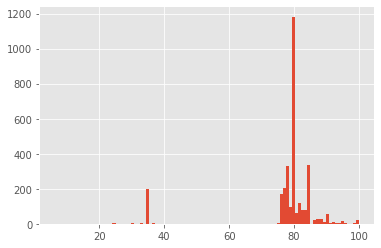

In [71]:
df['Efficiency'].hist(bins = 100)

In [72]:
df['OK'] = df['Efficiency'].apply(lambda x: 0 if x <= 40 else 1)

In [73]:
df['OK'].mean()

0.9277615808228054

In [74]:
df.head()

,OG,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp,OK
21,1.084,51.10,60,1.075,90.0,1.25,1.00,20.56,1
35,1.069,49.21,90,1.058,80.0,1.50,1.00,17.78,1
77,1.102,30.28,90,1.076,80.0,2.00,0.75,16.67,1
93,1.044,53.00,60,1.038,80.0,1.50,1.00,18.89,1
109,1.058,27.44,60,1.048,78.0,1.33,0.35,18.33,1


In [75]:
df['OK'].value_counts()

1    2864
0     223
Name: OK, dtype: int64

In [76]:
X = df[cols_for_model]
y = df.loc[:,"OK"]


In [77]:
X_train, X_test, label_train, \
    label_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [78]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, label_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, label_test)))

The score for kNN is
Training:  93.06%
Test set:  93.96%


In [79]:
logit = LogisticRegressionCV()
logit.fit(X_train, label_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, label_test)))

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The score for logistic regression is
Training:  92.92%
Test set:  94.61%


Unlike kNN, the logistic regression model has a probabiltiy method built into it. Let's look at the predicted probabilities for the first few observations.

In [80]:
# Let's do a prediction of the first 5 observations from logistic

logit.predict_proba(X_test[1:5])

array([[0.02089712, 0.97910288],
       [0.09929884, 0.90070116],
       [0.05345057, 0.94654943],
       [0.266127  , 0.733873  ]])

Let's look at the type of errors that these two classifiers made:

In [81]:
from sklearn.metrics import confusion_matrix

print("kNN confusion matrix: \n\n", confusion_matrix(label_test, knn.predict(X_test)))

kNN confusion matrix: 

 [[ 14  43]
 [ 13 857]]


i.e. the kNN confused two samples of species 1 as species 2, and one species 2 as a species 1, but managed to get all of the species 0 irises right. 

Note that `confusion[row_number][col_number]` tells us how many of the labels that were actually `row_number` were predicted to be `col_number` by our classifier. We can see that by predicting class 2 for everything (this is not data science, it's just for demonstration!).

We can make this a little prettier by passing the confusion matrix to `sns.heatmap`:

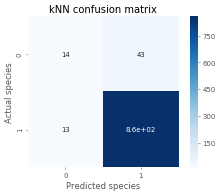

In [82]:
# Print confusion matrix for kNN
knn_confusion = confusion_matrix(label_test, knn.predict(X_test))
plt.figure(dpi=50)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('kNN confusion matrix');

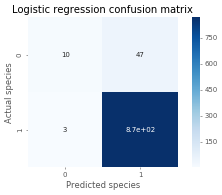

In [83]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(label_test, logit.predict(X_test))
plt.figure(dpi=50)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True,)

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Logistic regression confusion matrix');

plt.tight_layout()

plt.savefig("confusion_matrix_logit_iris")

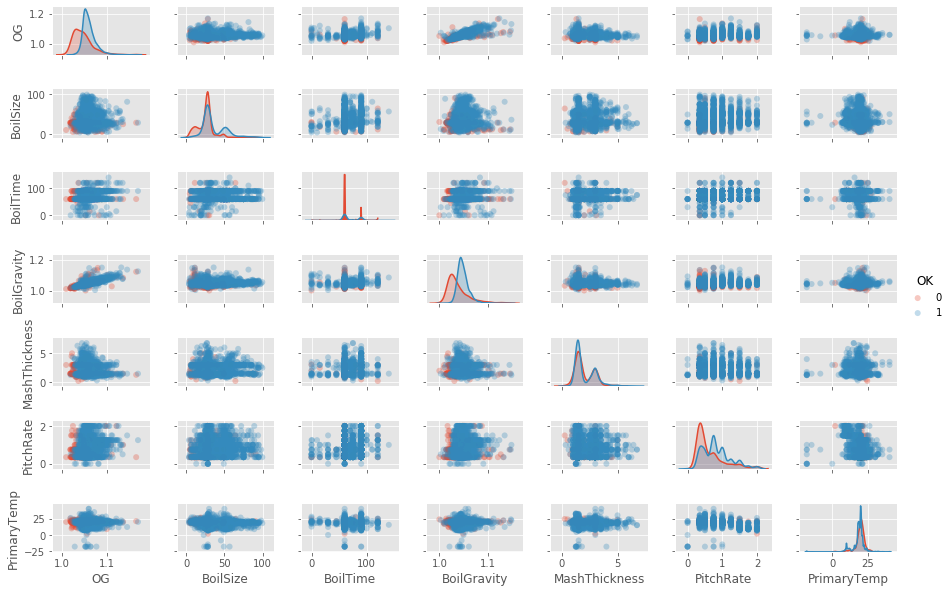

In [52]:
# sns.pairplot(df.drop('Efficiency', axis = 1), plot_kws=dict(alpha=.3, edgecolor='none'), height=1.2, aspect=1.5);
sns.pairplot(df, vars = df.drop(['OK', 'Efficiency'], axis = 1), plot_kws=dict(alpha=.3, edgecolor='none'), hue = 'OK', height=1.2, aspect=1.5);

---

## New metrics: precision and recall

We can introduce two new metrics:
- **Precision:** The fraction of postive predictions you made that were correct. 
  High precision means that if your model predicted a positive case, you believe it with high confidence. It doesn't tell us how many postive cases we missed (i.e. it doesn't tell us how sure we are about the cases we predicted were negative).
- **Recall**: The fraction of positive cases you predicted correctly.
  High recall means that you are confident that you didn't miss any positive cases. 
  
The easiest way to get high precision is to call a point positive only when you are very sure. The easiest way to get 100% recall is to predict all points to be positive, as you are guaranteed to label 100% of all positive cases. You should not optimize for either recall or precision -- you need to think about how to balance them against one another.

In formula:
$$ \text{Precision} = \frac{\text{(True positives)}}{\text{Predicted positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False postitives}}$$
and
$$ \text{Recall} = \frac{\text{True positives}}{\text{Actual positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False negatives}}$$

### Example calcuation: fraud when threshold = 0.5 

|_                            | predicted negative (legit) | predicted positive (fraud) | Total |
|-----------------------------| -------------------------- | -------------------------- | ----- |
| **actual negative (legit)** | 71058                      | 11                         | 71069 |
| **actual positive (fraud)** | 47                         | 86                         | 133   |
| **Total**                   | 71105                      | 97                         | 71202 |


For precision:
$$\text{Precision} = \frac{TP}{\text{predicted positive}} = \frac{86}{86 + 11} = 0.887$$
i.e. this 88.7% of the tests positive predictions are correct.

For recall:
$$\text{Recall} = \frac{TP}{\text{actual positives}} = \frac{86}{86+47} = 0.647$$
i.e. the model can only get (or 'remember'/'recall') 64.7% of fraudulent transactions.


### Example calculation: fraud when threshold = 0.06

|-                            | predicted negative (legit) | predicted positive (fraud) | Total |
|-----------------------------| -------------------------- | -------------------------- | ----- |
| **actual negative (legit)** | 71039                      | 30                         | 71069 |
| **actual positive (fraud)** | 23                         | 110                        | 133   |
| **Total**                   | 71062                      | 140                        | 71202 |

Calculating precision and recall:
* Precision = 110 / 140 = 78.5%
* Recall = 110 / 133 = 82.7%
i.e. by lowering the probability threshold before we label a transaction fraud, we caught more fraud (high recall), but we also investigated more innocent transactions (lower precision).

## Big takeaways:

* Using the **same** logistic regression model, we can change the threshold to bias toward more precision (making positives from test more relevant) or recall (increasing the fraction of postives found).
* Precision goes down as you decrease the threshold, while recall goes up. This is called the _precision-recall tradeoff_.
* Which is worse, low recall or low precision? Depends on the cost of making the different types of error.
* We just need the final predictions of the model to calculate precision and recall. We can get sklearn.metrics to calculate them for us

In [84]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = logit.predict(X_test)
print("Default threshold:")
print("Precision: {:6shuf.4f},   Recall: {:6.4f}".format(precision_score(label_test, y_predict), recall_score(label_test, y_predict)))

Default threshold:


ValueError: Invalid format specifier

In [85]:
# using the new threshold of 0.06
y_predict = (lm.predict_proba(X_test)[:,1] > 0.02)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

NameError: name 'lm' is not defined

In [86]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

NameError: name 'y_test' is not defined

In [87]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

NameError: name 'recall_curve' is not defined

<Figure size 480x320 with 0 Axes>

### F1 score: balancing precision vs. recall

A heuristic for finding a good balance is to use $F_1$ score: 

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

The goal here is to find a balance between a good recall score and a good precision score. We can calculate it manually.

For the default threshold we have

precision = 0.8810, recall = 0.6218

so

$$F_1 = 2\frac{(0.8810)(0.6218)}{0.8810 + 0.6218} = 0.7290$$

---
**STUDENT EXERCISE:**

Use `f1_score` from sklearn to check our calculation above. Look at the F1 score for (1) default threshold and (2) threshold of .06

---

### Generalizing the F1 score

As the name suggests, there is actually a whole family of $F_1$ scores. We have in general:

$$F_{\beta} = \frac{\text{precision} \times \text{recall}}{\text{weighted average of precision and recall}}$$

where the weighted average is given by

$$\text{weighted average} = \frac{\beta^2 \times \text{precision} + 1 \times \text{recall}}{\beta^2 + 1}$$

The rough interpretation is that $F_{\beta}$ attaches $\beta$ times more importance to recall than precision. 

## The ROC curve

We've already seen that we don't have to accept a 50% threshold cutoff. As we've seen, we can plot our models with different thresholds on the same chart and get a ROC curve. This curve plots the *true positive rate* on the y axis, and the *false positive rate* on the x axis. 

In [88]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])

NameError: name 'y_test' is not defined

In [89]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for BEER');
print("ROC AUC score = ", roc_auc_score(y_test, lm.predict_proba(X_test)[:,1]))

NameError: name 'fpr' is not defined

The intepretation of the _Area Under the Curve_ (AUC) is the probability that a randomly chosen positive example (in this case, fraud) has a higher score than the randomly chosen negative example (in this case, legitimate transactions).

We see here all the possible TPRs and FNRs that we could have. It is a nice metric because looking at the behavior of our model, we can choose later what we want the threshold to be.


**Question 1: What would a "perfect classifier" look like on this diagram?**

Upper left 

What is an example of data leakage? 

**Question 2: What is the significance of the diagonal line?**

**Question 3: Is it possible to get a classifier that dips below the dotted line?**

**Question 4: Can we read the threshold off the ROC curve above?**